In [290]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# make scripts the working directory
import IPython, os
notebook_name = IPython.extract_module_locals()[1]["__vsc_ipynb_file__"]
scripts_dir = os.path.join(os.path.dirname(os.path.dirname(notebook_name)), "scripts")
os.chdir(scripts_dir)

In [207]:
import logging
import pypsa
import os.path
import sys

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd

# from make_summary import assign_carriers
from _helpers import configure_logging, mock_snakemake
from plot_summary import rename_techs
from constants import PLOT_COST_UNITS, PLOT_CAP_UNITS,PLOT_SUPPLY_UNITS
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
from plot_network import plot_capex_map, plot_map, plot_energy_map
from _plot_utilities import fix_network_names_colors

logger = logging.getLogger(__name__)


In [208]:

snakemake = mock_snakemake(
    "plot_network",
    snakefile_path=os.path.abspath("../"),
    opts="ll",
    topology="current-and-neighbour",
    pathway="exponential175",
    planning_horizons="2060",
    heating_demand="positive",
)

configure_logging(snakemake, logger=logger)
config = snakemake.config
tech_colors = config["plotting"]["tech_colors"]


ntw_path = snakemake.input.network

# ntw_path = "/home/ivanra/documents/PyPSA-China-PIK/results/version-0325.175.1H/postnetworks/positive/postnetwork-ll-current+Neighbor-exponential175-2060.nc"
# ntw_path = "/home/ivanra/downloads/PaperResultsXiaowei_networks/postnetwork-ll-current+Neighbor-exponential175-2060.nc"
n = pypsa.Network(ntw_path)

2024-12-13 14:02:59,099 - _helpers.py - INFO - =========== NEW RUN ===========
2024-12-13 14:02:59,099 - _helpers.py - INFO - =========== NEW RUN ===========



RULES None

RULES None


2024-12-13 14:02:59,099 - _helpers.py - INFO - =========== NEW RUN ===========
2024-12-13 14:02:59,099 - _helpers.py - INFO - =========== NEW RUN ===========
INFO:__main__:=========== NEW RUN ===========
INFO:pypsa.io:Imported network postnetwork-ll-current-and-neighbour-exponential175-2060.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores


In [209]:
fix_network_names_colors(n, config)

/home/ivanra/documents/PyPSA-China-PIK/workflow/scripts/_plot_utilities.py:90: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [210]:
n.global_constraints

,type,investment_period,carrier_attribute,sense,constant,mu
GlobalConstraint,,,,,,
co2_limit,primary_energy,NaN,co2_emissions,<=,0.0,-114.844378


# plot map

In [211]:
from plot_network import plot_capex_map, plot_map

## plot capex

/home/ivanra/miniconda3/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".

/home/ivanra/miniconda3/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".

/home/ivanra/documents/PyPSA-China-PIK/workflow/scripts/plot_network.py:128: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/home/ivanra/documents/PyPSA-China-PIK/workflow/scripts/plot_network.py:335: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



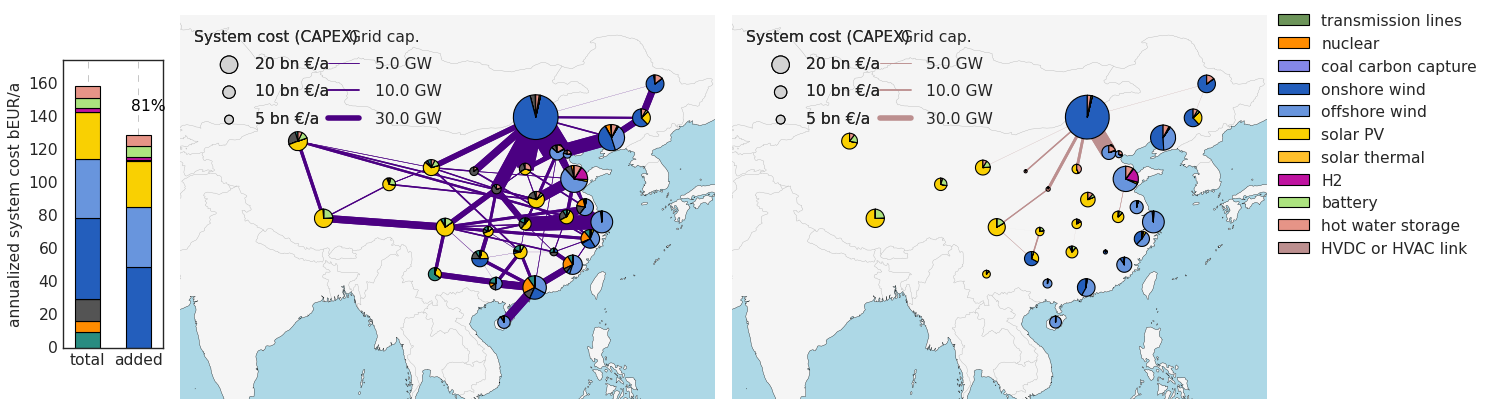

In [212]:
ax = plot_capex_map(n, 2060, snakemake.config["costs"]["discountrate"], config["plotting"])

In [213]:
from _plot_utilities import assign_location
from plot_network import plot_map
opts = config["plotting"]
plot_ntwk = n.copy()
assign_location(plot_ntwk)
cpx = plot_ntwk.statistics.capex(groupby=pypsa.statistics.get_bus_and_carrier)
cpx2 = cpx.droplevel(0)

In [214]:
anhui_stats = cpx.unstack().groupby(level=1).sum().loc["Anhui"]
anhui_stats.index = anhui_stats.index.map(rename_techs)
anhui_stats.where(anhui_stats > 0).dropna().sort_index()

carrier
Battery Storage         1.838612e+08
Heat Pump               4.512283e+08
Hydrogen Storage        2.982036e+05
Onshore Wind            1.115718e+05
Pumped Hydro Storage    2.701888e+08
Solar                   4.064626e+09
coal                    3.025543e+04
coal                    1.616829e+09
hydroelectricity        3.680158e+08
resistive heater        7.001112e+07
transmission lines      3.651463e+09
Name: Anhui, dtype: float64

In [215]:
from _helpers import calc_component_capex
from _plot_utilities import assign_location
from plot_network import make_cost_pies
costs_add = pd.DataFrame(index=n.buses.index)
costs_nom = pd.DataFrame(index=n.buses.index)
plot_ntwk = n.copy()
# Drop non-electric buses so they don't clutter the plot
plot_ntwk.buses.drop(plot_ntwk.buses.index[plot_ntwk.buses.carrier != "AC"], inplace=True)

assign_location(plot_ntwk)
for comp in plot_ntwk.iterate_components():
    # df_c = getattr(ntwk, comp)
    print(comp.name, comp.list_name)
    df_c = comp.df

    if df_c.empty:
        continue
    if not "capital_cost" in df_c.columns:
        continue

    df_c["nice_group"] = comp.name + "_" + df_c.carrier #.map(rename_techs)

    cap_name = "e_nom_opt" if comp.list_name == "stores" else "p_nom_opt"
    cap_before_ext = "e_nom" if comp.list_name == "stores" else "p_nom"

    costs_total = calc_component_capex(df_c, cap_name)
    costs_before_ext = calc_component_capex(df_c, cap_before_ext)
    costs_diff = costs_total - costs_before_ext

    costs_add = pd.concat([costs_add, costs_diff], axis=1)
    costs_nom = pd.concat([costs_nom, costs_total], axis=1)

costs_pathway = costs_add
cost_pie = make_cost_pies(plot_ntwk, costs_pathway, tech_colors)
cost_pie_nom = make_cost_pies(plot_ntwk, costs_nom, tech_colors)

       'Generator_onwind', 'Generator_solar', 'Generator_solar thermal',
       'Link_AC', 'Link_CHP coal', 'Link_CHP gas', 'Link_CO2 capture',
       'Link_H2', 'Link_H2 CHP', 'Link_OCGT gas', 'Link_Sabatier',
       'Link_battery', 'Link_biomass', 'Link_coal boiler', 'Link_gas boiler',
       'Link_heat pump', 'Link_resistive heater', 'Store_H2', 'Store_battery',
       'Store_water tanks'],
      dtype='object')
       'Generator_hydroelectricity', 'Generator_nuclear', 'Generator_offwind',
       'Generator_onwind', 'Generator_solar', 'Generator_solar thermal',
       'Link_AC', 'Link_CHP coal', 'Link_CHP gas', 'Link_CO2 capture',
       'Link_H2', 'Link_H2 CHP', 'Link_OCGT gas', 'Link_Sabatier',
       'Link_battery', 'Link_biomass', 'Link_coal boiler', 'Link_gas boiler',
       'Link_heat pump', 'Link_hydroelectricity', 'Link_resistive heater',
       'StorageUnit_PHS', 'Store_H2', 'Store_battery', 'Store_water tanks'],
      dtype='object')


Carrier carriers
Store stores
Link links
GlobalConstraint global_constraints
Bus buses
Load loads
StorageUnit storage_units
Generator generators
TransformerType transformer_types
LineType line_types


In [216]:
costs_nom.loc["Anhui"]

Store_CO2                     0.000000e+00
Store_CO2 capture             0.000000e+00
Store_H2                      3.736696e+06
Store_battery                 4.269556e+08
Store_biomass                 0.000000e+00
Store_gas                     0.000000e+00
Store_stations                0.000000e+00
Store_water tanks             1.397347e+08
Link_AC                       0.000000e+00
Link_CHP coal                 8.087826e+04
Link_CHP gas                  1.691827e+05
Link_CO2 capture              6.572017e+08
Link_H2                       2.982036e+05
Link_H2 CHP                   3.535522e+05
Link_OCGT gas                 2.560792e+08
Link_Sabatier                 2.485736e+04
Link_battery                  1.838612e+08
Link_battery discharger       0.000000e+00
Link_biomass                  9.910075e+08
Link_coal boiler              9.686037e+07
Link_gas boiler               3.536307e+05
Link_heat pump                4.512283e+08
Link_hydroelectricity         0.000000e+00
Link_resist

In [217]:
costs_nom.loc["Anhui"].where(costs_nom.loc["Anhui"] > 0).dropna().sort_index()

Generator_coal cc             3.025543e+04
Generator_coal power plant    1.616829e+09
Generator_hydroelectricity    3.680158e+08
Generator_onwind              1.115718e+05
Generator_solar               4.064626e+09
Generator_solar thermal       2.290003e+04
Link_CHP coal                 8.087826e+04
Link_CHP gas                  1.691827e+05
Link_CO2 capture              6.572017e+08
Link_H2                       2.982036e+05
Link_H2 CHP                   3.535522e+05
Link_OCGT gas                 2.560792e+08
Link_Sabatier                 2.485736e+04
Link_battery                  1.838612e+08
Link_biomass                  9.910075e+08
Link_coal boiler              9.686037e+07
Link_gas boiler               3.536307e+05
Link_heat pump                4.512283e+08
Link_resistive heater         7.001112e+07
StorageUnit_PHS               2.701888e+08
Store_H2                      3.736696e+06
Store_battery                 4.269556e+08
Store_water tanks             1.397347e+08
Name: Anhui

In [218]:
(+4.945283e+08+4.561884e+08+8.723083e+08+6.220741e+08+9.907787e+07+5.843623e+08+7.186157e+08+1.612604e+03+4.571001e+07)/1e9

3.8928665926040003

In [219]:
cpx[cpx.index.get_level_values(1) == "Anhui"].sort_index()

component    bus    carrier             
Generator    Anhui  Onshore Wind            1.115718e+05
                    Solar                   4.064626e+09
                    coal carbon capture     3.025543e+04
                    coal power plant        1.616829e+09
                    hydroelectricity        3.680158e+08
Link         Anhui  AC                      3.651463e+09
                    Battery Storage         1.838612e+08
                    Heat Pump               4.512283e+08
                    Hydrogen Storage        2.982036e+05
                    resistive heater        7.001112e+07
StorageUnit  Anhui  Pumped Hydro Storage    2.701888e+08
dtype: float64

In [220]:
cpx[("Link", "Anhui", slice(None))].sum()/1e9

4.35686190500496

In [221]:
carriers = (
    cost_pie.index.get_level_values(1)
    .unique()
    .union(cost_pie_nom.index.get_level_values(1).unique())
)
carriers = carriers.tolist()
df = pd.DataFrame(index=carriers, columns=["total", "added"])
df["total"] = cost_pie_nom.groupby(level=1).sum()
df["added"] = cost_pie.groupby(level=1).sum()

In [222]:
preferred_order = pd.Index(config["plotting"]["preferred_order"])
reordered = preferred_order.intersection(df.index).append(df.index.difference(preferred_order))

df.loc[reordered, df.columns]
df.sum()["added"]

390593609800.2749

In [223]:
cpx3 = cpx2["Anhui"].copy()
cpx3.index = cpx3.index.map(rename_techs)
cpx3

carrier
transmission lines      3.651463e+09
Battery Storage         1.838612e+08
Heat Pump               4.512283e+08
Hydrogen Storage        2.982036e+05
resistive heater        7.001112e+07
Pumped Hydro Storage    2.701888e+08
Onshore Wind            1.115718e+05
Solar                   4.064626e+09
coal                    3.025543e+04
coal                    1.616829e+09
hydroelectricity        3.680158e+08
dtype: float64

## plot electricy generation map

/home/ivanra/miniconda3/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



ValueError: Colors not defined for all elements in the second MultiIndex 

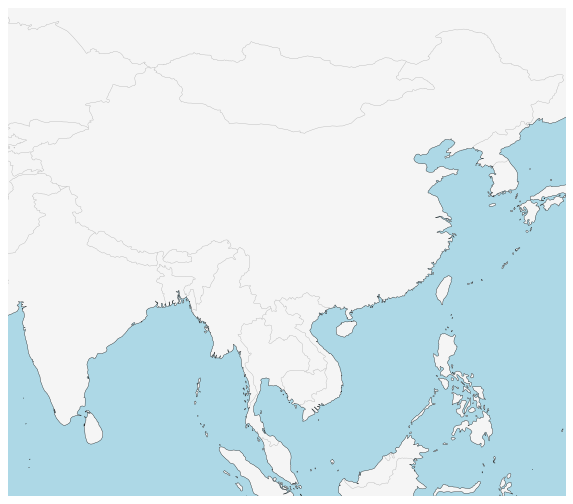

In [226]:
from plot_network import plot_energy_map
from _plot_utilities import set_plot_style
set_plot_style(
    style_config_file= r"/home/ivanra/documents/PyPSA-China-PIK/config/plotting_styles/network_map.mplstyle",
    #snakemake.config["plotting"]["network_style_config_file"],
    base_styles=["classic", "seaborn-v0_8-white"],
)
plot_energy_map(n,config["plotting"], carrier="AC")

/home/ivanra/miniconda3/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



<GeoAxes: >

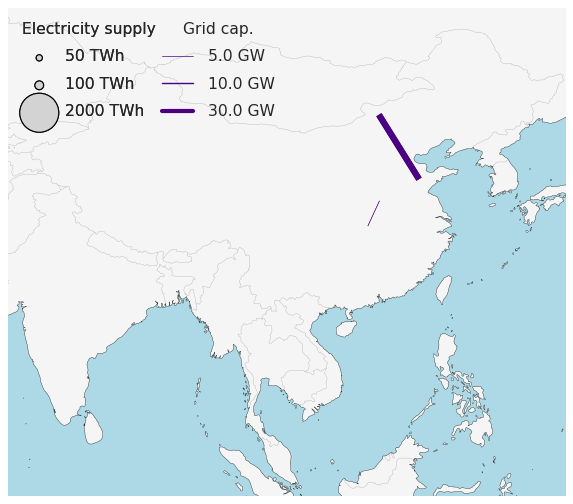

In [ ]:
plot_ntwk = n.copy()
carrier = "H2"
# avoid cluttering the plot
plot_ntwk.buses.drop(plot_ntwk.buses.index[plot_ntwk.buses.carrier != carrier], inplace=True)
plot_ntwk.links.drop(
    plot_ntwk.links.index[plot_ntwk.links.length == 0],
    inplace=True,
)

supply_pies = plot_ntwk.statistics.supply(
        groupby=pypsa.statistics.get_bus_and_carrier, bus_carrier=carrier, comps=["Generator"]
    ).droplevel(0)

# get all carrier types
carriers_list = supply_pies.index.get_level_values(1).unique()
carriers_list = carriers_list.tolist()

# TODO make line handling nicer
line_lower_threshold = 500.0
line_upper_threshold = 1e4
# Make figure
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(opts["energy_map"]["figsize"])
# get colors
bus_colors = plot_ntwk.carriers.loc[plot_ntwk.carriers.nice_name.isin(carriers_list), "color"]
bus_colors.rename(opts["nice_names"], inplace=True)
# Add the total costs
bus_size_factor = opts["energy_map"]["bus_size_factor"]/1e2
linewidth_factor = opts["energy_map"]["linewidth_factor"]*1
edges = pd.concat([plot_ntwk.lines.s_nom_opt, plot_ntwk.links.p_nom_opt])
edge_widths = (
    edges
    .clip(line_lower_threshold, edges.max())
    .replace(line_lower_threshold, 0)
)
preferred_order = pd.Index(opts["preferred_order"])
reordered = preferred_order.intersection(bus_colors.index).append(
    bus_colors.index.difference(preferred_order)
)

plot_map(
    plot_ntwk,
    tech_colors=plot_ntwk.carriers.color,
    edge_widths=edge_widths / linewidth_factor,
    bus_colors=bus_colors.loc[reordered],
    bus_sizes=supply_pies / 1,
    edge_colors="indigo",
    ax=ax,
    edge_unit_conv=PLOT_CAP_UNITS,
    bus_unit_conv=PLOT_SUPPLY_UNITS,
    add_legend=False,
    **opts["energy_map"],
)

## plot capacity

## plot cost

## Interactive plot map

In [ ]:

import numpy as np
# make names and link sizes, make sure we only plot AC, DC & statiosn
ac_links = n.links[n.links.carrier == "AC"]
colors = n.links.index.to_series().apply(lambda x: 'black' if 'ext' in x else 'pink')
widths = np.log(n.links.p_nom_opt + 3) / 2
widths[~widths.index.isin(ac_links.index)] = 0
widths[widths.index.str.contains('reversed')] = 0
names = n.links.copy()
names["name"] = names.index.values
names.loc[~names.index.isin(ac_links.index), "p_nom_opt"] = ""
names.loc[~names.index.isin(ac_links.index), "name"] = ""
buses = n.buses.copy()
buses["name"] = buses.apply(lambda x: f"{x.name}" if x.carrier == "AC" or x.carrier=="stations" else "", axis=1)
buses["sizes"] = buses.apply(lambda x:10 if x.carrier == "AC" or x.carrier=="stations" else 0, axis=1)
buses["colors"] = buses.apply(lambda x: "black" if x.carrier == "AC" else "red", axis=1)
buses.carrier.unique()
ax = n.iplot(link_colors=colors, link_widths=widths, link_text = names.p_nom_opt.astype(str) + names.name, bus_text=buses.name, bus_sizes=buses.sizes, bus_colors=buses.colors)

/tmp/ipykernel_12372/1096144582.py:10: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



In [ ]:
n.links[(n.links.length != 0)&(n.links.index.str.find("reversed")<0)].p_nom_opt.sort_values(ascending=False).round(2).head(20)

Link
Hebei-InnerMongolia positive                   152077.52
InnerMongolia-Shanxi positive                   92145.21
Hubei-Shanghai positive                         78291.74
Hebei-Liaoning positive                         73160.00
Shaanxi-InnerMongolia positive                  71532.59
Henan-Shandong positive                         56612.89
Guangdong-Hainan positive                       48493.04
InnerMongolia-Shandong H2 pipeline positive     44224.67
Guangdong-Guangxi ext positive                  41690.00
Sichuan-Tibet positive                          39768.84
Ningxia-InnerMongolia positive                  39692.92
Heilongjiang-Jilin positive                     37086.17
Anhui-Jiangsu positive                          36421.13
Jilin-Liaoning positive                         35852.34
Fujian-Guangdong positive                       34631.78
Hubei-Shaanxi positive                          31665.62
Guangdong-Yunnan ext positive                   31400.00
Shanghai-Zhejiang positive

### extendable lines

/home/ivanra/miniconda3/envs/pypsa-china/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning:

facecolor will have no effect as it has been defined as "never".



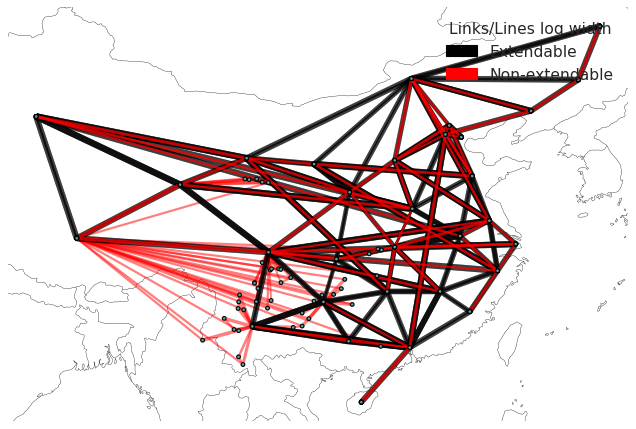

In [ ]:

fig, ax = plt.subplots(1, 1, figsize=(10, 10),subplot_kw={"projection":ccrs.PlateCarree()})
def width(x):
    return np.log10(x/1e6).where(x>1,0)
n.plot(ax = ax,link_colors=n.links.p_nom_extendable.apply(lambda x: "red" if not x else "black"),line_colors=n.lines.s_nom_extendable.apply(lambda x: "red" if not x else "black"), link_widths= width(n.links.p_nom_opt) , line_widths=width(n.lines.s_nom_opt), link_alpha=0.5)
# Create custom legend
import matplotlib.patches as mpatches
extendable_patch = mpatches.Patch(color='black', label='Extendable')
non_extendable_patch = mpatches.Patch(color='red', label='Non-extendable')
ax.legend(handles=[extendable_patch, non_extendable_patch], title = "Links/Lines log width")

# Shadow prices & prices

In [ ]:
n.global_constraints

,type,investment_period,carrier_attribute,sense,constant,mu
GlobalConstraint,,,,,,
co2_limit,primary_energy,NaN,co2_emissions,<=,0.0,-114.844378


# CO2 emissions

In [ ]:
CO2_CONV = 1e6 # t->Mt
def calc_co2(n:pypsa.Network, withdrawal_stores = ["CO2 capture"])->tuple[float,float,float]:
    """calc the co2 balance
    [DOES NOT INCLUDE GENERATING]
    Args:
        n (pypsa.Network): the network object
        withdrawal_stores (list, optional): names of stores. Defaults to ["CO2 capture"].

    Returns:
        tuple[float,float,float]: balance, gen, withdrawal
    """
    # emissions from generators (from fneumann course)
    emissions = (
    n.generators_t.p
    / n.generators.efficiency
    * n.generators.carrier.map(n.carriers.co2_emissions)
    )  # t/h
    gen_emissions = n.snapshot_weightings.generators @ emissions.sum(axis=1).div(CO2_CONV)  # Mt

    # withdrawal
    stores = n.stores_t.e.T.groupby(n.stores.carrier).sum()
    
    co2_cap = stores.iloc[:, -1].loc[withdrawal_stores].sum()/CO2_CONV # Mt

    return gen_emissions-co2_cap, gen_emissions, co2_cap



In [ ]:
n.links.carrier.unique()

array(['CO2 capture', 'biomass', 'hydroelectricity', 'stations', 'H2',
       'H2 CHP', 'Sabatier', 'heat pump', 'resistive heater',
       'coal boiler', 'gas boiler', 'OCGT gas', 'CHP gas', 'CHP coal',
       'water tanks', 'battery', 'battery discharger', 'AC'], dtype=object)

In [ ]:
def calc_co2_balance(n:pypsa.Network, withdrawal_stores = ["CO2 capture"], ax = None)->tuple[float,float,float]:
    """calc the co2 balance
    [DOES NOT INCLUDE GENERATING LINKSs]
    Args:
        n (pypsa.Network): the network object
        withdrawal_stores (list, optional): names of stores. Defaults to ["CO2 capture"].

    Returns:
        tuple[float,float,float]: balance, gen, withdrawal
    """

    # year *(assumes one planning year intended),
    year = int(np.round(n.snapshots.year.values.mean(),0))

    # emissions from generators (from fneumann course)
    emissions = (
    n.generators_t.p
    / n.generators.efficiency
    * n.generators.carrier.map(n.carriers.co2_emissions)
    )  # t/h
    emissions_carrier =(n.snapshot_weightings.generators @ emissions).groupby(n.generators.carrier).sum()
    
    # format and drop 0 values
    emissions_carrier = emissions_carrier.where(emissions_carrier > 0).dropna()
    emissions_carrier.rename(year, inplace=True)
    emissions_carrier = emissions_carrier.div(CO2_CONV).to_frame()
    # CO2 withdrawal
    stores = n.stores_t.e.T.groupby(n.stores.carrier).sum()
    co2_withdrawal = stores.iloc[:, -1].loc[withdrawal_stores]*-1/CO2_CONV # Mt
    co2_withdrawal.rename(year, inplace=True)
    co2_withdrawal = co2_withdrawal.to_frame()

    return pd.concat([emissions_carrier, co2_withdrawal])

co2_balance = calc_co2_balance(n)
co2_balance.to_csv("co2_balance.csv")

<Axes: xlabel='snapshot'>

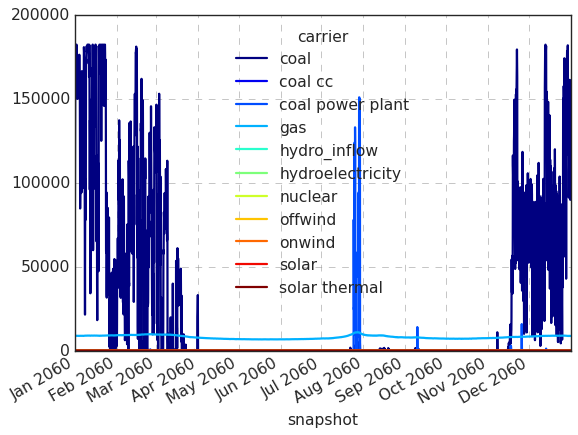

In [ ]:
fig, ax = plt.subplots()
# calc the t resolved CO2 emissions from generators
((n.generators_t.p/ n.generators.efficiency)* n.generators.carrier.map(n.carriers.co2_emissions)).T.groupby(n.generators.carrier).sum().T.plot(ax =ax, cmap ="jet")

Text(0, 0.5, 'cum CO2 emissions [t]')

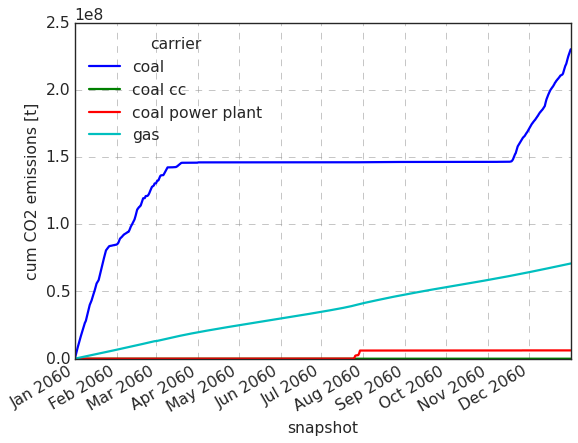

In [ ]:
gen_emissions = ((n.generators_t.p/ n.generators.efficiency)* n.generators.carrier.map(n.carriers.co2_emissions)).T.groupby(n.generators.carrier).sum().T.cumsum()
fig, ax = plt.subplots()
gen_emissions.where(gen_emissions>0).dropna(axis=1, how="all").plot(ax=ax)
ax.set_ylabel("cum CO2 emissions [t]")


Text(0, 0.5, 'carrier stock')

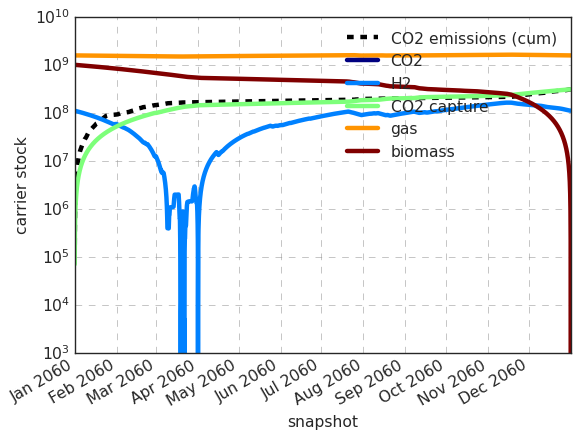

In [ ]:
fig, ax = plt.subplots()
# calc the t resolved CO2 emissions from generators
((n.generators_t.p/ n.generators.efficiency)* n.generators.carrier.map(n.carriers.co2_emissions)).T.groupby(n.generators.carrier).sum().sum().T.cumsum().plot(ax =ax, label = "CO2 emissions (cum)", lw=4, c ="black", ls = "--")
n.stores_t.e.T.groupby(n.stores.carrier).sum().loc[["CO2","H2", "CO2 capture", "gas", "biomass"]].T.plot(lw=4, cmap ="jet", ax =ax)
ax.legend()
ax.semilogy()
ax.set_ylim(1e3,1e10)
ax.set_ylabel("carrier stock")

## CO2 capture
! beware the store is the difference :)

In [ ]:
stores = n.stores_t.e.T.groupby(n.stores.carrier).sum()
diff = stores.iloc[:, -1] -stores.iloc[:, 0]
co2_cap = stores.iloc[:, -1].loc[["CO2 capture"]].sum()
co2_cap


307245838.1539315

<Axes: xlabel='snapshot'>

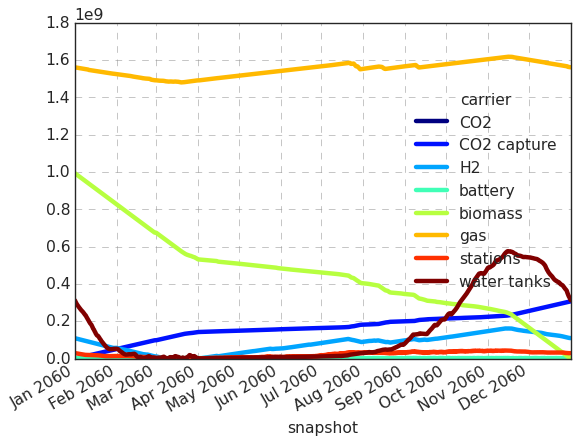

In [ ]:
n.stores_t.e.T.groupby(n.stores.carrier).sum().T.plot(lw=4, cmap ="jet")

In [ ]:
n.stores[n.stores.carrier == "CO2 capture"].e_nom_opt.sum()/1e6

30290.8235974056

In [ ]:
n.links[n.links.carrier == "CO2 capture"]

,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt,bus3,efficiency3,bus2,efficiency2,c_b
Link,,,,,,,,,,,,,,,,,,,,,
Anhui central biomass CHP capture,Anhui CO2,Anhui CO2 capture,,CO2 capture,0.95,True,0,25.0,0.0,0.0,...,NaN,NaN,1.0,1.0,4258.726588,,1.0,Anhui,-0.019,0.75
Beijing central biomass CHP capture,Beijing CO2,Beijing CO2 capture,,CO2 capture,0.95,True,0,25.0,0.0,0.0,...,NaN,NaN,1.0,1.0,39.904183,,1.0,Beijing,-0.019,0.75
Chongqing central biomass CHP capture,Chongqing CO2,Chongqing CO2 capture,,CO2 capture,0.95,True,0,25.0,0.0,0.0,...,NaN,NaN,1.0,1.0,573.156331,,1.0,Chongqing,-0.019,0.75
Fujian central biomass CHP capture,Fujian CO2,Fujian CO2 capture,,CO2 capture,0.95,True,0,25.0,0.0,0.0,...,NaN,NaN,1.0,1.0,194.365989,,1.0,Fujian,-0.019,0.75
Gansu central biomass CHP capture,Gansu CO2,Gansu CO2 capture,,CO2 capture,0.95,True,0,25.0,0.0,0.0,...,NaN,NaN,1.0,1.0,1097.784973,,1.0,Gansu,-0.019,0.75
Guangdong central biomass CHP capture,Guangdong CO2,Guangdong CO2 capture,,CO2 capture,0.95,True,0,25.0,0.0,0.0,...,NaN,NaN,1.0,1.0,510.013601,,1.0,Guangdong,-0.019,0.75
Guangxi central biomass CHP capture,Guangxi CO2,Guangxi CO2 capture,,CO2 capture,0.95,True,0,25.0,0.0,0.0,...,NaN,NaN,1.0,1.0,720.407064,,1.0,Guangxi,-0.019,0.75
Guizhou central biomass CHP capture,Guizhou CO2,Guizhou CO2 capture,,CO2 capture,0.95,True,0,25.0,0.0,0.0,...,NaN,NaN,1.0,1.0,731.396491,,1.0,Guizhou,-0.019,0.75
Hainan central biomass CHP capture,Hainan CO2,Hainan CO2 capture,,CO2 capture,0.95,True,0,25.0,0.0,0.0,...,NaN,NaN,1.0,1.0,68.473521,,1.0,Hainan,-0.019,0.75


# plot time series

In [ ]:
from plot_time_series import plot_energy_balance

/home/ivanra/miniconda3/envs/pypsa-china/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1798: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



Text(0.5, 1.0, 'Electricity Balance')

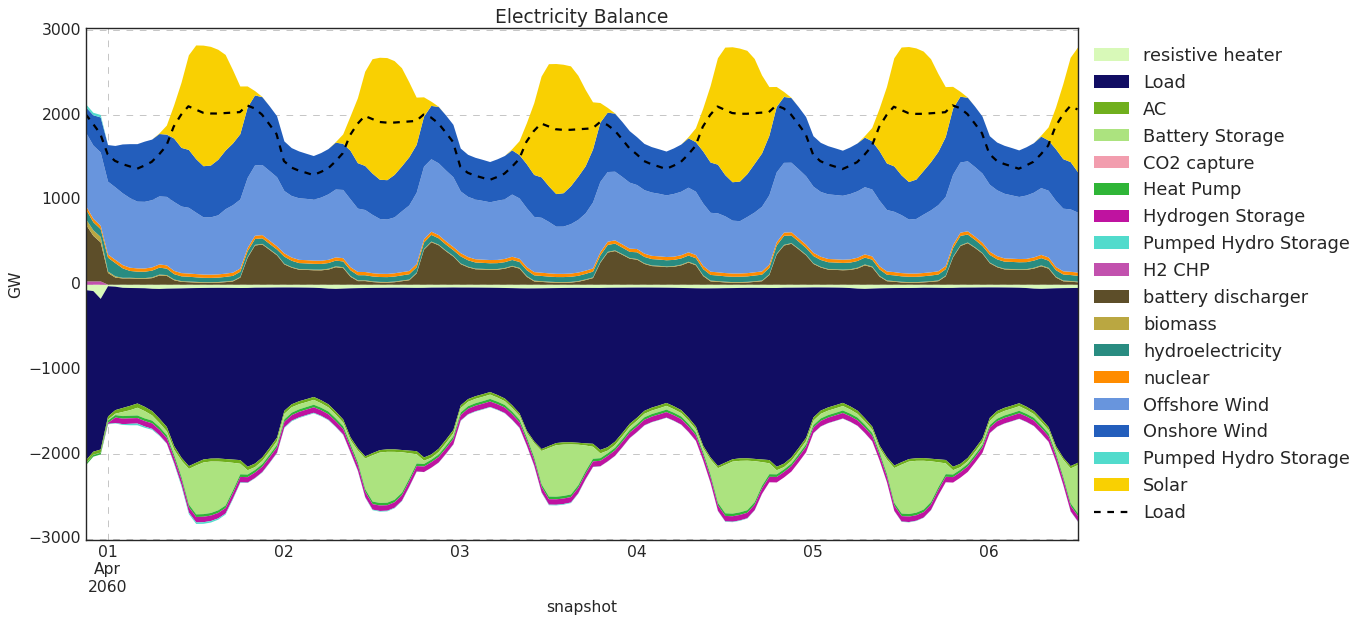

In [ ]:
ax = plot_energy_balance(n, config["plotting"], start_date="2060-03-31 21:00", end_date="2060-04-06 12:00:00")
ax.grid(axis='y')
ax.set_title("Electricity Balance")

/home/ivanra/miniconda3/envs/pypsa-china/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1798: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



Text(0.5, 1.0, 'Heat balance')

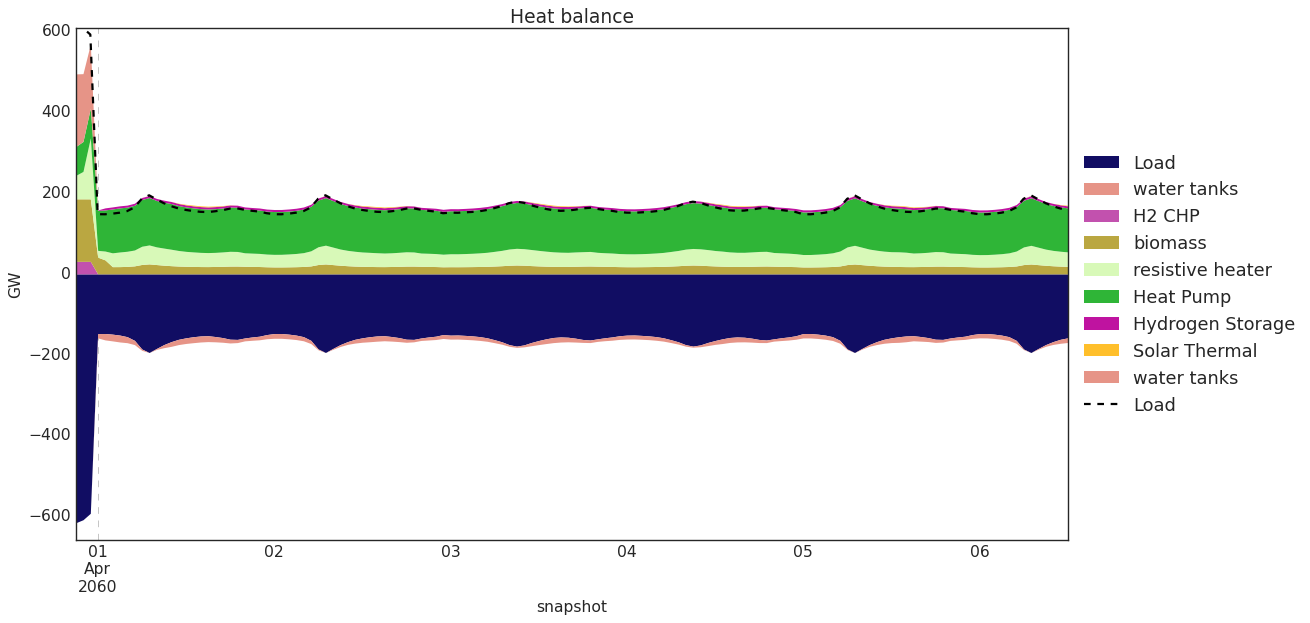

In [ ]:
ax = plot_energy_balance(n, config["plotting"], start_date="2060-03-31 21:00", end_date="2060-04-06 12:00:00", bus_carrier="heat")
ax.set_title("Heat balance")

Text(0, 0.5, 'EnergyDemand / GW')

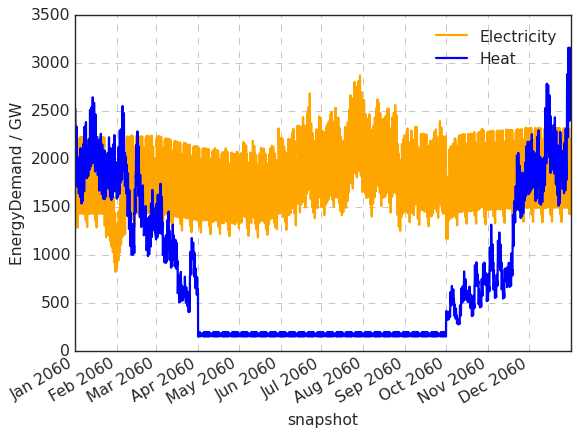

In [ ]:
fix, ax = plt.subplots()
ds_AC = n.statistics.withdrawal(bus_carrier="AC", aggregate_time=False).loc[("Load", "-")]/1e3
ds_heat = n.statistics.withdrawal(bus_carrier="heat", aggregate_time=False).loc[("Load", "-")]/1e3
ds_AC.plot(ax=ax, label="Electricity",  c="orange")
ds_heat.plot(ax=ax, label="Heat", c = "blue")
ax.legend()
ax.set_ylabel("EnergyDemand / GW")

In [ ]:
capacity_factors = n.statistics.capacity_factor(aggregate_time=False).loc[["Generator"]].droplevel(0).T

In [ ]:
capacity_factors["Onshore Wind"].mean(), capacity_factors["Offshore Wind"].mean(),  capacity_factors["Solar"].mean()

(0.3880127548953006, 0.9501118337187233, 0.26854415901686957)

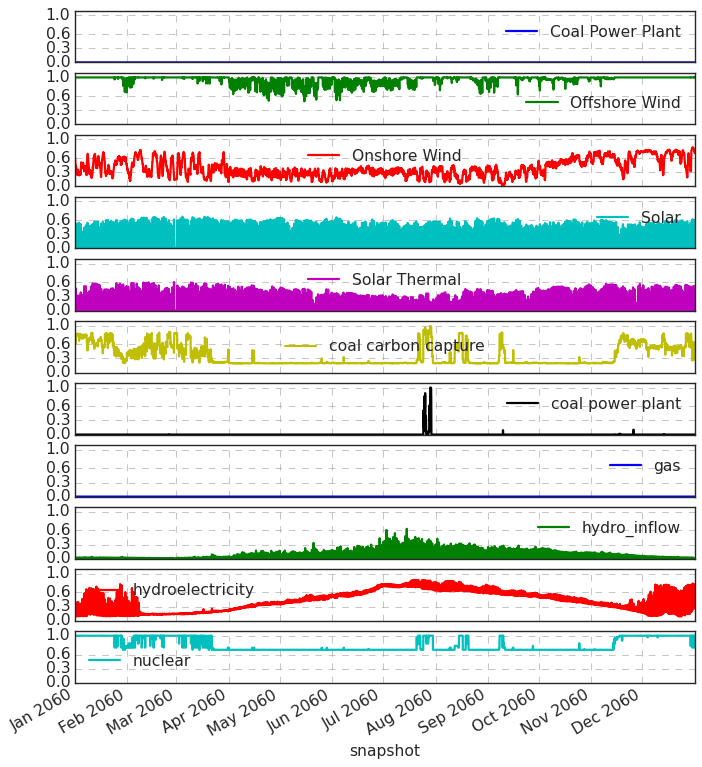

In [ ]:
axes = capacity_factors.dropna(axis=1, how="all").fillna(0).plot(subplots=True, figsize=(10,12))
for ax in axes:
    ax.set_ylim([0,1.1])
    ax.set_yticks([0,0.3, 0.6,1])

In [ ]:
n.generators[n.generators.carrier.isin(['onwind',
       'offwind'])].p_max_pu

Generator
Anhui onwind            1.0
Beijing onwind          1.0
Chongqing onwind        1.0
Fujian onwind           1.0
Gansu onwind            1.0
Guangdong onwind        1.0
Guangxi onwind          1.0
Guizhou onwind          1.0
Hainan onwind           1.0
Hebei onwind            1.0
Heilongjiang onwind     1.0
Henan onwind            1.0
Hubei onwind            1.0
Hunan onwind            1.0
InnerMongolia onwind    1.0
Jiangsu onwind          1.0
Jiangxi onwind          1.0
Jilin onwind            1.0
Liaoning onwind         1.0
Ningxia onwind          1.0
Qinghai onwind          1.0
Shaanxi onwind          1.0
Shandong onwind         1.0
Shanghai onwind         1.0
Shanxi onwind           1.0
Sichuan onwind          1.0
Tianjin onwind          1.0
Tibet onwind            1.0
Xinjiang onwind         1.0
Yunnan onwind           1.0
Zhejiang onwind         1.0
Fujian offwind          1.0
Guangdong offwind       1.0
Guangxi offwind         1.0
Hainan offwind          1.0
Hebei offw

In [ ]:
n.generators[n.generators.carrier.isin(['onwind',"offwind"])]

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
Anhui onwind,Anhui,PQ,,0.0,0.0,True,0.0,9.949591e+04,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,2.052264e+00
Beijing onwind,Beijing,PQ,,0.0,0.0,True,0.0,1.349827e+04,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,5.653062e-01
Chongqing onwind,Chongqing,PQ,,0.0,0.0,True,0.0,4.771031e+04,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,4.843604e+00
Fujian onwind,Fujian,PQ,,0.0,0.0,True,0.0,5.485693e+04,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,1.448486e+04
Gansu onwind,Gansu,PQ,,0.0,0.0,True,0.0,3.860880e+05,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,6.841376e-01
Guangdong onwind,Guangdong,PQ,,0.0,0.0,True,0.0,1.398810e+05,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,8.545075e+04
Guangxi onwind,Guangxi,PQ,,0.0,0.0,True,0.0,1.610014e+05,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,3.235803e+00
Guizhou onwind,Guizhou,PQ,,0.0,0.0,True,0.0,1.223712e+05,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,8.785740e+04
Hainan onwind,Hainan,PQ,,0.0,0.0,True,0.0,3.224695e+04,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,5.337701e-01


In [ ]:
cap_fac = n.generators_t.p_max_pu
cap_fac_w = cap_fac[[c for c in cap_fac.columns if c.find("wind")>=0]]
cap_fac_offw = cap_fac[[c for c in cap_fac.columns if c.find("offwind")>=0]]

cap_fac_onw = cap_fac[[c for c in cap_fac.columns if c.find("onwind")>=0]]

In [ ]:
cap_fac_onw.columns.to_list()

['Anhui onwind',
 'Beijing onwind',
 'Chongqing onwind',
 'Fujian onwind',
 'Gansu onwind',
 'Guangdong onwind',
 'Guangxi onwind',
 'Guizhou onwind',
 'Hainan onwind',
 'Hebei onwind',
 'Heilongjiang onwind',
 'Henan onwind',
 'Hubei onwind',
 'Hunan onwind',
 'InnerMongolia onwind',
 'Jiangsu onwind',
 'Jiangxi onwind',
 'Jilin onwind',
 'Liaoning onwind',
 'Ningxia onwind',
 'Qinghai onwind',
 'Shaanxi onwind',
 'Shandong onwind',
 'Shanghai onwind',
 'Shanxi onwind',
 'Sichuan onwind',
 'Tianjin onwind',
 'Tibet onwind',
 'Xinjiang onwind',
 'Yunnan onwind',
 'Zhejiang onwind']

In [ ]:
cap_fac_w.T.groupby(n.generators.carrier).sum()

snapshot,2060-01-01 00:00:00,2060-01-01 01:00:00,2060-01-01 02:00:00,2060-01-01 03:00:00,2060-01-01 04:00:00,2060-01-01 05:00:00,2060-01-01 06:00:00,2060-01-01 07:00:00,2060-01-01 08:00:00,2060-01-01 09:00:00,...,2060-12-31 14:00:00,2060-12-31 15:00:00,2060-12-31 16:00:00,2060-12-31 17:00:00,2060-12-31 18:00:00,2060-12-31 19:00:00,2060-12-31 20:00:00,2060-12-31 21:00:00,2060-12-31 22:00:00,2060-12-31 23:00:00
carrier,,,,,,,,,,,,,,,,,,,,,
onwind,6.877028,6.52428,6.196098,5.932312,5.671942,5.397353,4.854107,4.699002,4.554771,4.248003,...,10.641065,10.471895,10.209996,10.310072,9.982366,10.524711,10.910823,11.06365,11.031201,10.793276


# Pypsa eur

# Plot time series (dev sandbox)

Text(0, 0.5, 'GW')

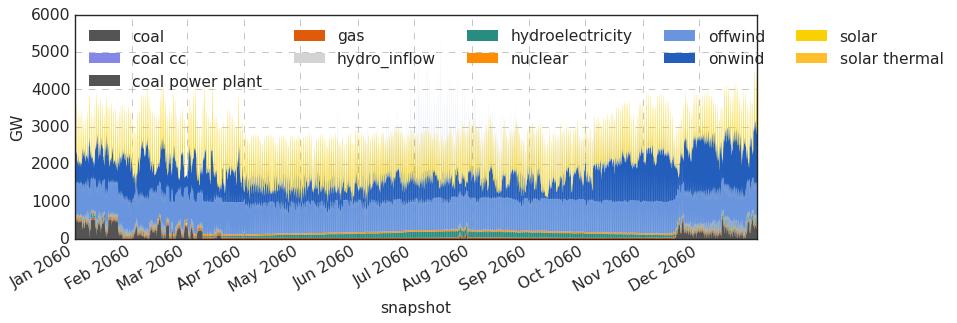

In [ ]:
p_by_carrier = n.generators_t.p.T.groupby(n.generators.carrier).sum().T.div(1e3)
fig, ax = plt.subplots(figsize=(11, 4))

p_by_carrier.plot(
    kind="area",
    ax=ax,
    linewidth=0,
    # cmap="tab20b",
    color = p_by_carrier.columns.map(n.carriers.color),
)

ax.legend(ncol=5, loc="upper left", frameon=False)

ax.set_ylabel("GW")

# ax.set_ylim(0, 80);

# COSTS

In [ ]:
# from plot_summary_all import plot_pathway_costs
# data_paths = {
#     "energy": [os.path.join(p, "energy.csv") for p in paths],
#     "costs": [os.path.join(p, "costs.csv") for p in paths],
#     "co2_price": [os.path.join(p, "metrics.csv") for p in paths],
#     "prices": [os.path.join(p, "prices.csv") for p in paths],
# }
# plot_pathway_costs(data_paths["costs"], config["plotting"], fig_name=None)

<Axes: xlabel='snapshot'>

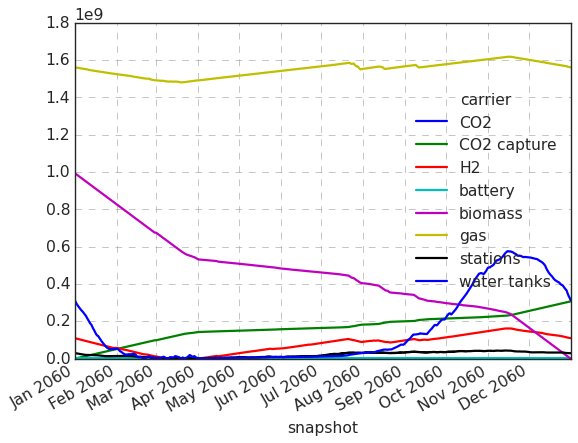

In [237]:
n.stores_t.e.T.groupby(n.stores.carrier).sum().T.plot()

In [256]:
flow = n.stores_t.p.T.groupby(n.stores.carrier).sum()
flow[flow>0].fillna(0).T.sum()

carrier
CO2            0.000000e+00
CO2 capture    0.000000e+00
H2             2.156200e+08
battery        1.189951e+09
biomass        9.944686e+08
gas            2.067881e+08
stations       3.248722e+08
water tanks    5.683646e+08
dtype: float64

In [246]:
stores = n.stores_t.e.T.groupby(n.stores.carrier).sum()
stores

snapshot,2060-01-01 00:00:00,2060-01-01 01:00:00,2060-01-01 02:00:00,2060-01-01 03:00:00,2060-01-01 04:00:00,2060-01-01 05:00:00,2060-01-01 06:00:00,2060-01-01 07:00:00,2060-01-01 08:00:00,2060-01-01 09:00:00,...,2060-12-31 14:00:00,2060-12-31 15:00:00,2060-12-31 16:00:00,2060-12-31 17:00:00,2060-12-31 18:00:00,2060-12-31 19:00:00,2060-12-31 20:00:00,2060-12-31 21:00:00,2060-12-31 22:00:00,2060-12-31 23:00:00
carrier,,,,,,,,,,,,,,,,,,,,,
CO2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
CO2 capture,6.957519e+04,1.391504e+05,2.087256e+05,2.783008e+05,3.478760e+05,4.174512e+05,4.870265e+05,5.566018e+05,6.261771e+05,6.957524e+05,...,3.066197e+08,3.066892e+08,3.067588e+08,3.068284e+08,3.068980e+08,3.069675e+08,3.070371e+08,3.071067e+08,3.071763e+08,3.072458e+08
H2,1.100436e+08,1.099660e+08,1.098884e+08,1.098109e+08,1.097333e+08,1.096557e+08,1.095781e+08,1.095004e+08,1.094228e+08,1.093451e+08,...,1.107191e+08,1.106884e+08,1.106284e+08,1.105675e+08,1.104898e+08,1.104122e+08,1.103395e+08,1.102660e+08,1.101884e+08,1.101108e+08
battery,2.128660e+06,2.075678e+06,2.048229e+06,2.027510e+06,2.017363e+06,1.977078e+06,1.870985e+06,1.683456e+06,1.443422e+06,1.218344e+06,...,2.875693e+06,3.522974e+06,3.997898e+06,4.225387e+06,4.098123e+06,3.686148e+06,3.240095e+06,2.829548e+06,2.491850e+06,2.230855e+06
biomass,9.942434e+08,9.940182e+08,9.937930e+08,9.935678e+08,9.933426e+08,9.931174e+08,9.928922e+08,9.926670e+08,9.924418e+08,9.922166e+08,...,2.026763e+06,1.801569e+06,1.576375e+06,1.351180e+06,1.125984e+06,9.007872e+05,6.755908e+05,4.503946e+05,2.251987e+05,2.701411e+00
gas,1.561033e+09,1.560984e+09,1.560935e+09,1.560886e+09,1.560837e+09,1.560788e+09,1.560739e+09,1.560690e+09,1.560641e+09,1.560592e+09,...,1.561525e+09,1.561476e+09,1.561427e+09,1.561377e+09,1.561328e+09,1.561279e+09,1.561229e+09,1.561180e+09,1.561131e+09,1.561082e+09
stations,2.959122e+07,2.957814e+07,2.956506e+07,2.955201e+07,2.953900e+07,2.952605e+07,2.951319e+07,2.950041e+07,2.948771e+07,2.947507e+07,...,2.955637e+07,2.955405e+07,2.954654e+07,2.953732e+07,2.952474e+07,2.951209e+07,2.949935e+07,2.948653e+07,2.947362e+07,2.946063e+07
water tanks,3.129905e+08,3.127757e+08,3.125290e+08,3.122638e+08,3.119515e+08,3.115158e+08,3.107595e+08,3.098939e+08,3.091019e+08,3.083635e+08,...,3.189664e+08,3.185045e+08,3.179984e+08,3.173543e+08,3.166076e+08,3.158520e+08,3.151483e+08,3.144751e+08,3.138210e+08,3.132033e+08


In [273]:
config["plotting"]["nice_names"]["AC"]

'AC'

In [276]:

    loads = n.statistics.revenue(
        comps="Load", groupby=pypsa.statistics.get_bus_carrier
    ) / n.statistics.withdrawal(comps="Load", groupby=pypsa.statistics.get_bus_carrier)


In [277]:
loads.rename(index={"AC": "electricity"}, inplace=True)
loads

bus_carrier
electricity   -26.533780
heat          -33.577829
Name: objective, dtype: float64

In [267]:
114.844477+28.538271

143.382748

In [268]:
n.global_constraints

,type,investment_period,carrier_attribute,sense,constant,mu
GlobalConstraint,,,,,,
co2_limit,primary_energy,NaN,co2_emissions,<=,0.0,-114.844378


In [328]:
n.buses_t.marginal_price.apply(lambda x: (x <= 0).sum()).groupby(n.buses.carrier).sum().loc["AC"]

0

In [ ]:
buses = n.buses.index[n.buses.carrier == "AC"]
n.buses_t.marginal_price[buses].std

65.93288763009328

In [312]:
from make_summary import make_summaries
make_summaries({("exp175-paper", 2060):ntw_path})["curtailment_pc"]

INFO:make_summary:Make summary for scenario ('exp175-paper', 2060), using /home/ivanra/documents/PyPSA-China-PIK/results/version-0412.175.1H/postnetworks/positive/postnetwork-ll-current-and-neighbour-exponential175-2060.nc


INFO:pypsa.io:Imported network postnetwork-ll-current-and-neighbour-exponential175-2060.nc has buses, carriers, generators, global_constraints, links, loads, storage_units, stores


nodal_costs
nodal_capacities
nodal_cfs
cfs
costs
co2_balance
capacities
curtailment_pc
energy
supply
supply_energy


time_averaged_prices
weighted_prices
price_statistics
market_values
metrics


/home/ivanra/documents/PyPSA-China-PIK/workflow/scripts/make_summary.py:500: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/home/ivanra/documents/PyPSA-China-PIK/workflow/scripts/make_summary.py:500: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/home/ivanra/documents/PyPSA-China-PIK/workflow/scripts/make_summary.py:500: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/home/ivanra/documents/PyPSA-China-PIK/workflow/scripts/make_summary.py:500: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/home/ivanra/documents/PyPSA-China-PIK/workflow/scripts/make_summary.py:500: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.

/home/ivanra/documents/PyPSA-China-PIK/workflow/scripts/make_summ

pathway,exp175-paper
planning_horizons,2060
carrier,
coal,0.000
coal cc,0.000
coal power plant,0.000
gas,0.000
hydro_inflow,0.000
hydroelectricity,0.674
nuclear,0.000
offwind,0.000


In [297]:
    p_avail_by_carr = (
        n.generators_t.p_max_pu.multiply(n.generators.p_nom_opt)
        .sum()
        .groupby(n.generators.carrier)
        .sum()
    )
    used = n.generators_t.p.sum().groupby(n.generators.carrier).sum()


In [310]:
(p_avail_by_carr - used).clip(0) / p_avail_by_carr

carrier
coal                         NaN
coal cc                      NaN
coal power plant             NaN
gas                          NaN
hydro_inflow        4.821930e-14
hydroelectricity    6.735328e-03
nuclear                      NaN
offwind                      NaN
onwind              1.197359e-01
solar               7.617781e-03
solar thermal       4.430945e-03
dtype: float64

In [282]:
w = n.statistics.withdrawal(comps="Store")
w[w==0] = n.statistics.supply(comps="Store")[w==0]
pd.concat([ loads,n.statistics.revenue(comps="Store")/ w])

electricity         -26.533780
heat                -33.577829
Battery Storage      10.560029
CO2                        NaN
CO2 capture        -114.844477
Hydrogen Storage     20.868032
biomass              25.414969
gas                   0.000035
stations              9.980251
water tanks          15.417327
dtype: float64

# STATS

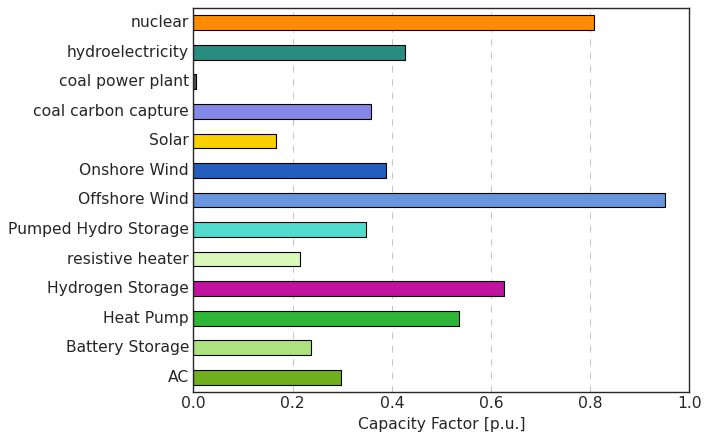

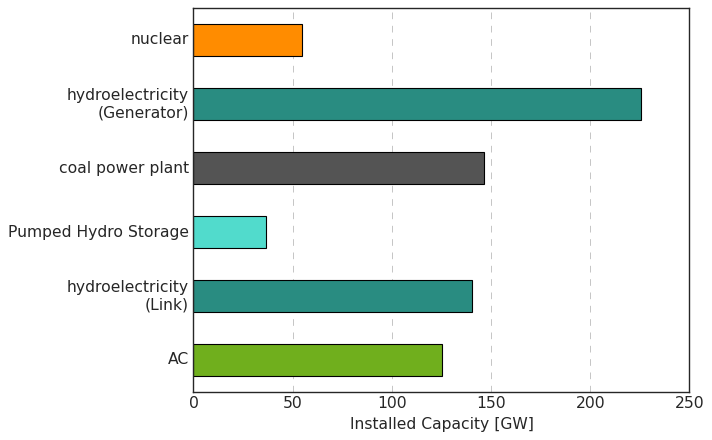

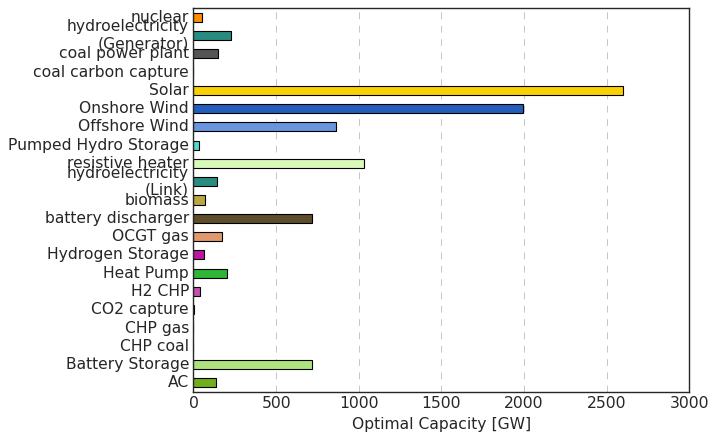

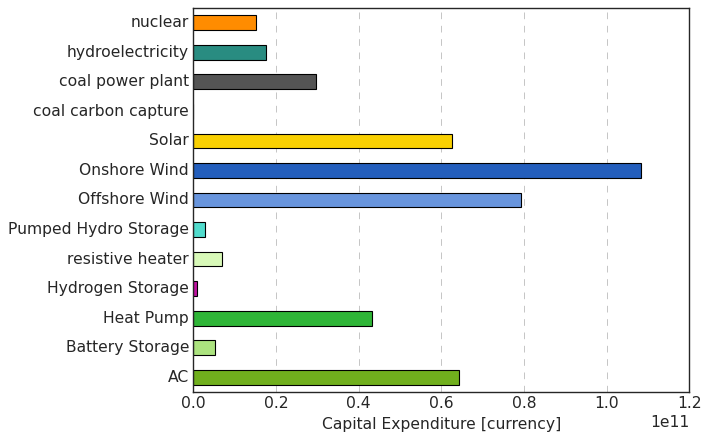

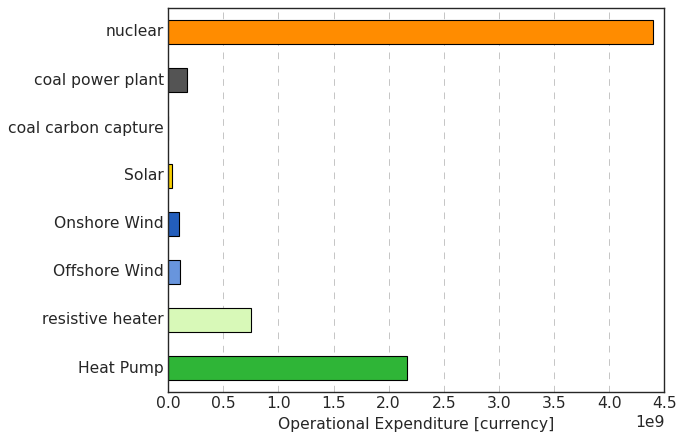

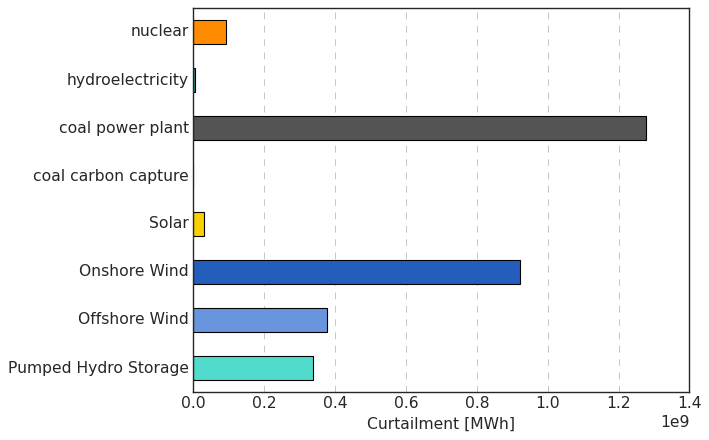

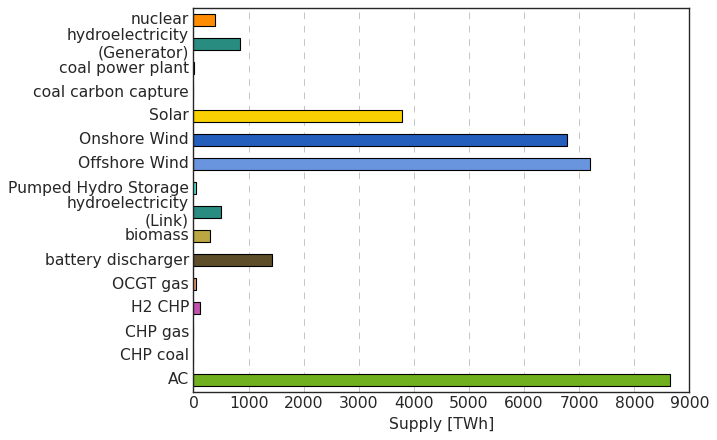

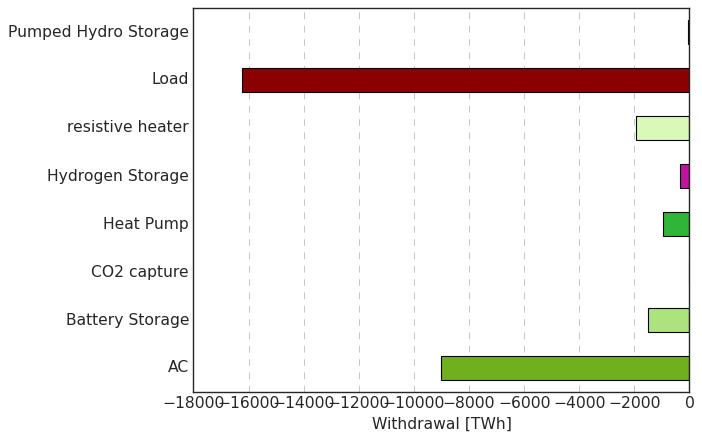

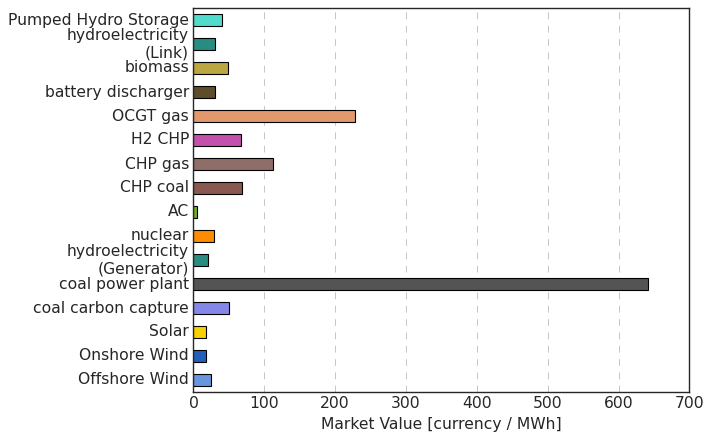

In [ ]:
bus_carrier = "AC"
n.loads.carrier = "load"
n.carriers.loc["load", ["nice_name", "color"]] = "Load", "darkred"
colors = n.carriers.set_index("nice_name").color.where(
    lambda s: s != "", "lightgrey"
)

def rename_index(ds):
    specific = ds.index.map(lambda x: f"{x[1]}\n({x[0]})")
    generic = ds.index.get_level_values("carrier")
    duplicated = generic.duplicated(keep=False)
    index = specific.where(duplicated, generic)
    return ds.set_axis(index)

def plot_static_per_carrier(ds, ax, drop_zero=True):
    if drop_zero:
        ds = ds[ds != 0]
    ds = ds.dropna()
    c = colors[ds.index.get_level_values("carrier")]
    ds = ds.pipe(rename_index)
    label = f"{ds.attrs['name']} [{ds.attrs['unit']}]"
    ds.plot.barh(color=c.values, xlabel=label, ax=ax)
    ax.grid(axis="y")

fig, ax = plt.subplots()
ds = n.statistics.capacity_factor(bus_carrier=bus_carrier).dropna()
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.installed_capacity(bus_carrier=bus_carrier).dropna()
if "Line" in ds.index:
    ds = ds.drop("Line")
ds = ds.drop(("Generator", "Load"), errors="ignore")
ds = ds / 1e3
ds.attrs["unit"] = "GW"
plot_static_per_carrier(ds.abs(), ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.optimal_capacity(bus_carrier=bus_carrier)
if "Line" in ds.index:
    ds = ds.drop("Line")
ds = ds.drop(("Generator", "Load"), errors="ignore")
ds = ds.abs() / 1e3
ds.attrs["unit"] = "GW"
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.capex(bus_carrier=bus_carrier)
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.opex(bus_carrier=bus_carrier)
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.curtailment(bus_carrier=bus_carrier)
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.supply(bus_carrier=bus_carrier)
if "Line" in ds.index:
    ds = ds.drop("Line")
ds = ds / 1e6
ds.attrs["unit"] = "TWh"
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.withdrawal(bus_carrier=bus_carrier)
if "Line" in ds.index:
    ds = ds.drop("Line")
ds = ds / -1e6
ds.attrs["unit"] = "TWh"
plot_static_per_carrier(ds, ax)
plt.show()

fig, ax = plt.subplots()
ds = n.statistics.market_value(bus_carrier=bus_carrier)
plot_static_per_carrier(ds, ax)
plt.show()

In [ ]:
ds = n.statistics.installed_capacity(bus_carrier=bus_carrier).dropna()

ds = ds[ds != 0]
ds = ds.dropna()
c = colors[ds.index.get_level_values("carrier")]
# ds = ds.pipe(rename_index)
# label = f"{ds.attrs['name']} [{ds.attrs['unit']}]"
# ds.plot.barh(color=c.values, xlabel=label, ax=ax)
# ax.grid(axis="y")
ds

component    carrier             
Link         AC                     -125478.08721
             hydroelectricity        140322.00000
StorageUnit  Pumped Hydro Storage     36390.00000
Generator    coal power plant        146354.00000
             hydroelectricity        225378.00000
             nuclear                  54647.00000
dtype: float64

# Network topology

In [ ]:
n.determine_network_topology()
n.sub_networks["n_branches"] = [
    len(sn.branches()) for sn in n.sub_networks.obj
]
n.sub_networks["n_buses"] = [len(sn.buses()) for sn in n.sub_networks.obj]

n.sub_networks



,carrier,slack_bus,obj,n_branches,n_buses
SubNetwork,,,,,
0,AC,Anhui,<pypsa.components.SubNetwork object at 0x7fc6e...,0,1
1,AC,Beijing,<pypsa.components.SubNetwork object at 0x7fc6e...,0,1
2,AC,Chongqing,<pypsa.components.SubNetwork object at 0x7fc6e...,0,1
3,AC,Fujian,<pypsa.components.SubNetwork object at 0x7fc6e...,0,1
4,AC,Gansu,<pypsa.components.SubNetwork object at 0x7fc6e...,0,1
...,...,...,...,...,...
410,battery,Tianjin battery,<pypsa.components.SubNetwork object at 0x7fc6e...,0,1
411,battery,Tibet battery,<pypsa.components.SubNetwork object at 0x7fc6e...,0,1
412,battery,Xinjiang battery,<pypsa.components.SubNetwork object at 0x7fc6e...,0,1


# EXAMPLES